In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In this notebook, we demonstrate how to apply a Naive Bayes classifier to a numerical toy dataset. There are two main differences with respect to the categorical example in the previous notebook. Firstly, the likelihood function has to be some kind of density function rather than a mass function. For this particular example we fit a Gaussian distribution for each feature/class cobination. And secondly, using a probability density function makes it unnecessary to apply Laplacian smoothing to account for values in the test set not present in the training set. 

## Generate a numerical toy dataset

We use one 2D Gaussian distribution to sample data for class 0 and two 2D Gaussian distributions to sample data for class 1. 

In [2]:
np.random.seed(0)

In [3]:
MEAN_A = [0, 0]
MEAN_B = [2, 2]
MEAN_C = [-4, 0]
COV_A = [[1, 1], [1, 3]]
COV_B = [[4, 1], [1, 2]]
COV_C = [[2, 1], [1, 2]]
N_A = 120
N_B = 60
N_C = 20

In [4]:
X_A = np.concatenate((np.random.multivariate_normal(MEAN_A, COV_A, N_A),
                     np.zeros((N_A, 1))), 
                     axis = 1)
X_B = np.concatenate((np.concatenate((np.random.multivariate_normal(MEAN_B, COV_B, N_B),
                                      np.random.multivariate_normal(MEAN_C, COV_C, N_C))),
                     np.ones((N_B + N_C, 1))),
                     axis = 1)

In [5]:
df = pd.DataFrame(np.concatenate((X_A, X_B)), columns = ['feature_1', 'feature_2', 'label'])

In [6]:
df

,feature_1,feature_2,label
0,-1.530327,-2.894222,0.0
1,-2.276623,-1.014468,0.0
2,-0.629523,-3.474359,0.0
3,-0.564788,-1.666234,0.0
4,-0.217350,0.296467,0.0
...,...,...,...
195,-4.537331,-0.852241,1.0
196,-2.424116,-0.710156,1.0
197,-3.104117,-0.181030,1.0
198,-5.857619,-0.243857,1.0


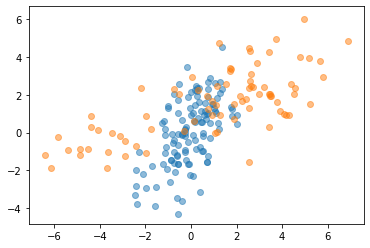

In [7]:
fig, ax = plt.subplots()
_ = ax.scatter(df[df.label == 0].feature_1, df[df.label == 0].feature_2, color = 'C0', alpha = 0.5)
_ = ax.scatter(df[df.label == 1].feature_1, df[df.label == 1].feature_2, color = 'C1', alpha = 0.5)

## Fit the model

After splitting the dataset into a training and a test set, we use the training set to infer the prior and likelihood distributions. 

In [8]:
df = df.sample(frac = 1)
df.index = range(len(df))
df_training = df[0:math.ceil(0.8 * len(df))].copy()
df_test = df[math.ceil(0.8 * len(df)):].copy()

In [9]:
prior = df_training.groupby('label')['label'].count().rename('prior')
prior = prior / prior.sum()
prior

label
0.0    0.6
1.0    0.4
Name: prior, dtype: float64

In [10]:
# Estimate first feature's likelihood parameters from the training data 
likelihood_1 = df_training.groupby('label')['feature_1'].agg(mean_1 = np.mean, std_1 = np.std)
likelihood_1

,mean_1,std_1
label,,
0.0,-0.095084,0.981376
1.0,0.940090,3.268776


In [11]:
# Estimate second feature's likelihood parameters from the training data 
likelihood_2 = df_training.groupby('label')['feature_2'].agg(mean_2 = np.mean, std_2 = np.std)
likelihood_2

,mean_2,std_2
label,,
0.0,-0.001835,1.739854
1.0,1.567218,1.842690


## Predict for the test data

In [12]:
def classification(df, prior, likelihood_1, likelihood_2):
    df['posterior_0'] = df.apply(lambda x: prior[0] * \
                                           norm(loc = likelihood_1.mean_1[0], 
                                                scale = likelihood_1.std_1[0]).pdf(x.feature_1) * \
                                           norm(loc = likelihood_2.mean_2[0], 
                                                scale = likelihood_2.std_2[0]).pdf(x.feature_2), 
                                 axis = 1)

    df['posterior_1'] = df.apply(lambda x: prior[1] * \
                                           norm(loc = likelihood_1.mean_1[1], 
                                                scale = likelihood_1.std_1[1]).pdf(x.feature_1) * \
                                           norm(loc = likelihood_2.mean_2[1], 
                                                scale = likelihood_2.std_2[1]).pdf(x.feature_2), 
                                 axis = 1)

    df['predicted'] = (df.posterior_1 > df.posterior_0).astype(int)

In [13]:
classification(df_test, prior, likelihood_1, likelihood_2)

In [14]:
accuracy = (df_test['predicted'] == df_test['label']).sum() / len(df_test)
print('Prediction accuracy: ' + str(accuracy))

Prediction accuracy: 0.825


In [15]:
confusion = [[(df_test[df_test['label'] == 0]['predicted'] == 0).sum(),
              (df_test[df_test['label'] == 0]['predicted'] == 1).sum()],
             [(df_test[df_test['label'] == 1]['predicted'] == 0).sum(),
             (df_test[df_test['label'] == 1]['predicted'] == 1).sum()]]
print('Confusion matrix:')
pd.DataFrame(data = confusion, columns = ['predicted 0', 'predicted 1'], index = ['class 0', 'class 1'])

Confusion matrix:


,predicted 0,predicted 1
class 0,22,2
class 1,5,11


## Visualising the decision boundary

The following section shows the training data and the test data in two separated plots on which we are also displaying the fitted model's decision boundary. 

In [16]:
RESOLUTION = 100
x = np.linspace(-7, 7, RESOLUTION)
y = np.linspace(-5, 7, RESOLUTION)
xx, yy = np.meshgrid(x, y)
boundaries = pd.DataFrame(np.concatenate((xx.reshape(RESOLUTION ** 2, 1), 
                                          yy.reshape(RESOLUTION ** 2, 1)), axis = 1),
                          columns = ['feature_1', 'feature_2'])

In [17]:
classification(boundaries, prior, likelihood_1, likelihood_2)

In [18]:
def plot_boundaries(boundaries, df):
    fig, ax = plt.subplots()
    ext = [-7, 7, -5, 7]
    colormap = plt.cm.RdYlBu
    ax.imshow(boundaries['predicted'].values.reshape(RESOLUTION, RESOLUTION), 
              zorder = 0, 
              extent = ext, 
              alpha = 0.5, 
              cmap = colormap, 
              origin = 'lower')
    _ = ax.scatter(df[df.label == 0].feature_1, df[df.label == 0].feature_2, color = colormap(0))
    _ = ax.scatter(df[df.label == 1].feature_1, df[df.label == 1].feature_2, color = colormap(256))

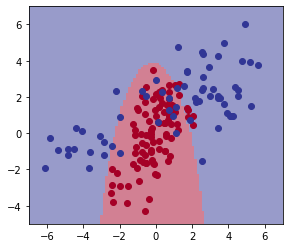

In [19]:
plot_boundaries(boundaries, df_training)

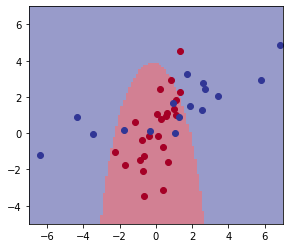

In [20]:
plot_boundaries(boundaries, df_test)